# 情绪分析：使用循环神经网络
:label:`sec_sentiment_rnn`

与词相似性和类比任务一样，我们也可以将预训练的词向量应用于情绪分析。由于 :numref:`sec_sentiment` 中的 IMDB 评论数据集不是很大，因此使用在大规模语体上预训练的文本表示法可能会减少模型的过度拟合。正如 :numref:`fig_nlp-map-sa-rnn` 中所示的一个具体示例，我们将使用预训练的 GloVE 模型表示每个令牌，并将这些令牌表示形式输入多层双向 RNN 以获取文本序列表示形式，这将转换为情绪分析输出 :cite:`Maas.Daly.Pham.ea.2011`。对于同一个下游应用程序，我们稍后将考虑不同的架构选择。 

![This section feeds pretrained GloVe to an RNN-based architecture for sentiment analysis.](../img/nlp-map-sa-rnn.svg)
:label:`fig_nlp-map-sa-rnn`


In [1]:
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn, rnn
from d2l import mxnet as d2l

npx.set_np()

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## 用 RNN 表示单个文本

在文本分类任务（例如情绪分析）中，长度不同的文本序列将转换为固定长度的类别。在接下来的 `BiRNN` 类中，虽然文本序列的每个标记通过嵌入层（`self.embedding`）获取其单独的预训练 GLOVE 表示形式（`self.embedding`），但整个序列由双向 RNN (`self.encoder`) 进行编码。更具体地说，双向 LSTM 在初始和最后一个时间步长的隐藏状态（在最后一层）被连接为文本序列的表示形式。然后，这个单一的文本表示形式由具有两个输出（“正” 和 “负”）的完全连接的图层（`self.decoder`）转换为输出类别。


In [2]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

让我们构建一个具有两个隐藏图层的双向 RNN 来表示情绪分析的单个文本。


In [3]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [4]:
net.initialize(init.Xavier(), ctx=devices)

## 加载预训练的词向量

下面我们加载预训练的 100 维（需要与 `embed_size` 一致）Glove 嵌入词汇中的代币。


In [5]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

为词汇中的所有标记打印矢量的形状。


In [6]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

(49346, 100)

我们使用这些预训练的单词矢量来表示评论中的标记，并且在训练期间不会更新这些向量。


In [7]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

## 训练和评估模型

现在我们可以训练双向 RNN 进行情绪分析。


loss 0.311, train acc 0.870, test acc 0.851
487.0 examples/sec on [gpu(0), gpu(1)]


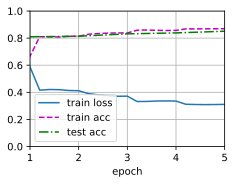

In [8]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

我们定义以下函数来使用训练的模型 `net` 预测文本序列的情绪。


In [9]:
#@save
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = np.array(vocab[sequence.split()], ctx=d2l.try_gpu())
    label = np.argmax(net(sequence.reshape(1, -1)), axis=1)
    return 'positive' if label == 1 else 'negative'

最后，让我们使用训练有素的模型来预测两个简单句子的情绪。


In [10]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [11]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## 摘要

* 预训练的单词向量可以表示文本序列中的单个标记。
* 双向 RNN 可以表示文本序列，例如通过在初始和最后时间步长的隐藏状态串联起来。可以使用完全连接的图层将此单个文本表示形式转换为类别。

## 练习

1. 增加时代的数量。你能提高训练和测试的准确度吗？调整其他超参数怎么样？
1. 使用较大的预训练词矢量，例如 300 维 Glove 嵌入。它能提高分类准确性吗？
1. 我们可以通过使用 SPPacy 标记化来提高分类准确性吗？你需要安装 SPacy (`pip install spacy`) 并安装英语软件包 (`python -m spacy download en`)。在代码中，首先，导入 SPACY（`import spacy`）。然后，加载 SPacy 英语软件包（`spacy_en = spacy.load('en')`）。最后，定义函数 `def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]` 并替换原来的 `tokenizer` 函数。请注意 Glove 和 SPACY 中的不同形式的短语令牌。例如，短语 “纽约” 在 Glove 中采用 “纽约” 的形式，在 SPacy 标记化后采用 “纽约” 的形式，以 “纽约” 的形式。


[Discussions](https://discuss.d2l.ai/t/392)
